In [32]:
import os
import numpy as np
import torch
from tqdm import tqdm
import torch.utils.data as data_utils
import torchvision.datasets
import torchvision.transforms as transforms
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

trans = transforms.Compose([transforms.ToTensor(),
        # transforms.Normalize((0.5, ), (0.5, )),
    ])
train_dataset = torchvision.datasets.MNIST(root="datasets", train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root="datasets", train=False,download=True, transform=trans)

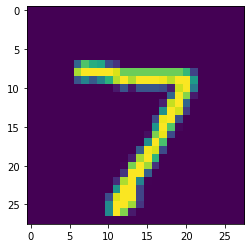

In [33]:
plt.imshow((test_dataset.data.float()[0]/255).numpy())

In [2]:
import os
import numpy as np
import torch
from tqdm import tqdm
import torch.utils.data as data_utils
import torchvision.datasets
import torchvision.transforms as transforms
from skimage import io
from torch.utils.data import Dataset

class BatchLoadDataset(Dataset):

    def __init__(self, maskPath, imgPath, imgSize, transform=None, maskExt="png"):

        self.transform = transform
        self.imgs = os.listdir(imgPath)
        self.masks = os.listdir(maskPath)
        self.maskExt = maskExt

        self.allImgs = torch.zeros([len(self.imgs),3, imgSize,imgSize], dtype=torch.float32)
        self.allMasks = torch.zeros([len(self.masks),1, imgSize,imgSize], dtype=torch.int8)

        # for idx in tqdm(range(len(self.imgs))):
        for idx in tqdm(range(10)):
            
            mask_path = os.path.join(self.maskPath, self.imgs[idx][:-3] + self.maskExt)
            mask = io.imread(mask_path)

            img_path = os.path.join(self.imgPath, self.imgs[idx])
            image = io.imread(img_path)
            # if len(mask.shape) < 3:
            #     image = np.expand_dims(image, axis = 2)

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            
            self.allImgs[idx] = mask.squeeze(0)
            self.allMasks[idx] = image.squeeze(0)

        # self.final.to("cuda")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.allImgs[idx], self.allMasks[idx]
    

def get_data_loader(args):

    if args.dataset == 'cifar':
        trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        train_dataset = torchvision.datasets.CIFAR10(root=args.dataroot, train=True, download=args.download, transform=trans)

    elif args.dataset == 'stl10':
        trans = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
        ])
        train_dataset = torchvision.datasets.STL10(root=args.dataroot, split='train', download=args.download, transform=trans)

    elif args.dataset == 'JSRT':
        image_size = args.image_size
        train_dataset = BatchLoadDataset(root=args.dataroot,imgSize = image_size, 
                                imgTransform=transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5)*args.imgC, (0.5)*args.imgC),
                                ]),
                                maskTransform=transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                ]), maskExt="png")
    

    assert train_dataset

    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    return train_dataloader

In [ ]:
class Args():
    def __init__(self):
        self.dataset = 'JSRT'
        self.dataroot = '/content/drive/MyDrive/JSRT'
        self.image_size = 256
        self.batch_size = 4
        self.download = False
        self.imgC = 3

args = Args()
get_data_loader(args)

In [19]:
import torch
import torch.nn as nn


class UpTranspose2d(nn.Module):

    '''
    Doubles input image size
    Stride assumed to be 2 and padding depends on kernel size.
    Leaky ReLu generally used in GANs & BatchNorm does not preserve the independence between images,
    therefore instance norm used.
    '''

    def __init__(self, ch_in, ch_out, kernelSize = 4, leak = 0.2, stride = 2):
        super().__init__()

        self.upTrans = nn.ConvTranspose2d(ch_in, ch_out, kernel_size=kernelSize, stride = stride, padding=(kernelSize//2 - 1))
        self.norm = nn.InstanceNorm2d(ch_out, affine=True)
        self.actFn = nn.LeakyReLU(leak, inplace=True)
        
    def forward(self, image):

        x = self.upTrans(image)
        x = self.actFn(self.norm(x))
        return x

class UpSampleConv(nn.Module):

    '''
    Doubles input image size
    Nearest Neighbour Upsample doubles image size followed by two Conv Layers as used in ResNet
    '''

    def __init__(self, ch_in, ch_out,kernelSize = 3, mode = 'nearest'):
        super().__init__()

        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=kernelSize, padding = (kernelSize-1)//2)
        self.norm1 = nn.BatchNorm2d(ch_out, affine=True)
        self.actFn1 = nn.ReLU()
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=kernelSize, padding = (kernelSize-1)//2)
        self.norm2 = nn.BatchNorm2d(ch_out, affine=True)
        self.actFn2 = nn.ReLU()
        
    def forward(self, image):

        x = self.actFn1(self.norm1(self.conv1(image)))
        x = self.actFn2(self.norm2(self.conv2(x)))
        return x
    
class GeneratorTrans(nn.Module):

    def __init__(self, channels, kernelSize=4):
        super().__init__()

        self.gen = nn.ModuleList([UpTranspose2d(channels[i], channels[i+1], kernelSize) for i in range(len(channels) - 2)])
        self.output = nn.ConvTranspose2d(channels[-2], channels[-1], kernel_size=kernelSize, stride = 2, padding=(kernelSize//2 - 1))

    def forward(self, image):
            
        for block in self.gen:
            image = block(image)
            print(image.shape)
    
        output = torch.tanh(self.output(image))
        return output

class GeneratorUpSample(nn.Module):

    def __init__(self, channels, kernelSize=3):
        super().__init__()

        self.gen = nn.ModuleList([UpSampleConv(channels[i], channels[i+1], kernelSize) for i in range(len(channels) - 2)])
        self.upSample = nn.Upsample(scale_factor=2, mode='nearest') 
        self.output = nn.Conv2d(channels[-2], channels[-1], kernel_size=kernelSize, padding = (kernelSize-1)//2)


    def forward(self, image):

        for block in self.gen:
            image = block(self.upSample(image))
            print(image.shape)

        output = torch.tanh(self.output(self.upSample(image)))
        return output

class DownConv2d(nn.Module):

    '''
    Halves input image size
    Using stride = 2 instead of Pooling.
    '''

    def __init__(self, ch_in, ch_out,kernelSize):
        super().__init__()

        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernelSize, stride = 2, padding = kernelSize//2 - 1)
        self.norm = nn.InstanceNorm2d(ch_out, affine=True)
        self.actFn = nn.ReLU()
        
    def forward(self, image):

        x = self.actFn(self.norm(self.conv(image)))
        return x

class Discriminator(nn.Module):
    def __init__(self, channels, kernelSize=4):
        super().__init__()

        self.dis = nn.ModuleList([DownConv2d(channels[i], channels[i+1], kernelSize) for i in range(len(channels) - 2)])
        self.out = nn.Conv2d(in_channels=channels[-2], out_channels=channels[-1], kernel_size=kernelSize)

    def forward(self, image):
        
        for block in self.dis:
            image = block(image)
            # print(image.shape)
        return self.out(image)

In [22]:
latent_len = 100
n_classes = 1
img_size = 256
n_channels = 3
channelsG = [latent_len, 64, 128, 128, 128, 64, 32, 32,n_channels]
channelsD = [n_channels, 64, 128, 128, 128, 256, 512, 1]

criterion = nn.BCEWithLogitsLoss()

bs = 4
epochs = 1
D_epochs = 1


# G = GeneratorUpSample(channelsG)
G = GeneratorTrans(channelsG)
D = Discriminator(channelsD)

optimizerG = torch.optim.Adam(G.parameters(), lr=0.001)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.001)

In [ ]:
for i in range(epochs):
    
    # Training Discriminator

    for _ in range(D_epochs):
        
        optimizerD.zero_grad()

        with torch.no_grad():
            z = torch.rand(bs,latent_len,1,1)
            fake_imgs = G(z)

        print(fake_imgs.shape)

        output = D(fake_imgs).flatten()
        labels = torch.tensor([0]*bs).float()
        lossF = criterion(output, labels)

        real_imgs = (torch.rand((bs,n_channels,img_size,img_size)) - 0.5)/0.5
        output = D(real_imgs).flatten()
        labels = torch.tensor([1]*bs).float()
        lossR = criterion(output, labels)

        lossD = lossR + lossF
        lossD.backward()
        optimizerD.step()

    ## Training Generator
    optimizerG.zero_grad()
    z = torch.rand(bs,latent_len,1,1)
    fake_imgs = G(z)
    output = D(fake_imgs).flatten()

    label = torch.tensor([1]*bs).float()
    lossG = criterion(output, label)
    lossG.backward()
    optimizerG.step()

In [ ]:
channelsDown = [n_channels, 64, 128, 128, 128, 256, latent_len]
channelsUp = [latent_len, 256, 128, 128, 128, 64 ,n_channels]


class UNet(nn.Module):

    def __init__(self, channels, kernelSizeUp=3, kernelSizeDown=4):
        super().__init__()


        self.dis = nn.ModuleList([DownConv2d(channels[i], channels[i+1], kernelSize=4) for i in range(len(channels) - 2)])
        self.out = nn.Conv2d(in_channels=channels[-2], out_channels=channels[-1], kernel_size=kernelSizeDown)

        
        self.gen = nn.ModuleList([UpSampleConv(channels[i], channels[i+1], kernelSize=3) for i in range(len(channels) - 2)])
        self.upSample = nn.Upsample(scale_factor=2, mode='nearest') 
        self.output = nn.Conv2d(channels[-2], channels[-1], kernel_size=kernelSizeUp, padding = (kernelSizeUp-1)//2)
        


    def forward(self, image):

        li = []
        for block in self.dis:
            image = block(image)
            li.append(image)
        self.out(image)

            
        for block in self.gen:
            image = block(self.upSample(image))
            print(image.shape)

        output = torch.tanh(self.output(self.upSample(image)))
        return output

        return self.out(image)

In [ ]:
# UNet Architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(3,64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv7 = nn.Conv2d(256, 512, 3)
        self.conv8 = nn.Conv2d(512, 512, 3)
        self.bn7 = nn.BatchNorm2d(512)
        self.bn8 = nn.BatchNorm2d(512)
        self.upconv1 = nn.ConvTranspose2d(512,256,2, stride = 2)

        self.conv9 = nn.Conv2d(512, 256, 3)
        self.conv10 = nn.Conv2d(256, 256, 3)
        self.bn9 = nn.BatchNorm2d(256)
        self.bn10 = nn.BatchNorm2d(256)
        self.upconv2 = nn.ConvTranspose2d(256,128,2, stride = 2)

        self.conv11 = nn.Conv2d(256, 128, 3)
        self.conv12 = nn.Conv2d(128, 128, 3)
        self.bn11 = nn.BatchNorm2d(128)
        self.bn12 = nn.BatchNorm2d(128)
        self.upconv3 = nn.ConvTranspose2d(128,64,2, stride = 2)

        self.conv13 = nn.Conv2d(128, 64, 3)
        self.conv14 = nn.Conv2d(64, 64, 3)
        self.conv15 = nn.Conv2d(64, 1, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.bn14 = nn.BatchNorm2d(64)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x1 = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x1)

        x = F.relu(self.bn3(self.conv3(x)))
        x2 = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x2)

        x = F.relu(self.bn5(self.conv5(x)))
        x3 = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x3)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.upconv1(x)

        lpad = (x3.shape[2] - x.shape[2])//2
        tpad = (x3.shape[3] - x.shape[3])//2
        x = torch.cat((x3[:, :,lpad:-lpad, tpad:-tpad],x), 1)
        x = self.bn9(F.relu(self.conv9(x)))
        x = self.bn10(F.relu(self.conv10(x)))
        x = self.upconv2(x)

        lpad = (x2.shape[2] - x.shape[2])//2
        tpad = (x2.shape[3] - x.shape[3])//2
        x = torch.cat((x2[:, :,lpad:-lpad, tpad:-tpad],x), 1)
        x = self.bn11(F.relu(self.conv11(x)))
        x = self.bn12(F.relu(self.conv12(x)))
        x = self.upconv3(x)


        lpad = (x1.shape[2] - x.shape[2])//2
        tpad = (x1.shape[3] - x.shape[3])//2
        x = torch.cat((x1[:, :,lpad:-lpad, tpad:-tpad],x), 1)
        x = self.bn13(F.relu(self.conv13(x)))
        x = self.bn14(F.relu(self.conv14(x)))
        x = self.conv15(x)
        x = x[:,:,2:-2,2:-2]

        return x.squeeze(1)